# Getting Started
In this notebook, we'll walk through an example on how to use the algorithm in this repository. We assume that the asset price evolution is governed by a jump-diffusion process. In traditional asset pricing, the independent jumps are driven by a Poisson process. To model the price evolution, we generate fake 5-minute intraday logarithmic returns using the following dynamics for the log-process of the stock price, $X(t) \coloneqq \log S(t)$:

$\begin{equation}
    \text{d} X(t) = \mu\text{d}t + \sigma \text{d}W^{\mathbb{P}}(t) + J\text{d}X_{\mathcal{P}}(t),
\end{equation}$


## Note on the code
The algorithm is wrapped up together in the `VarianceDecomposition` class. However, if there is a need, the Python wrapper of individual steps of the algorithm (coded as C-extensions) can be imported from `src.vol_decompisition`.

In [1]:
import numpy as np
import pandas as pd

from src import VarianceDecomposition
from src.utils import generate_jump_diffusion_process, plot_overview

# 5-minute frequency
# delta = 1/288; representing 5-minute intervals in 24-hour day
freq = 5
delta = 1.0 / 288.0

# significance of jump detection
alpha = 0.99

return_df = generate_jump_diffusion_process(
    X0=np.log(100.),         # Initial log price of the stock (log(S0))
    start_date="2010-01-02",
    end_date="2025-12-30",
    mu=0.08,                 # drift term (annual)
    sigma=0.15,              # volatility (annual)
    lambda_J=15.0,           # expected jumps per year
    mu_J=0.0,                # mean jump magnitude
    sigma_J=0.01,            # volatility of jump magnitude
    intraday_freq=freq,      # minutes
)
return_df["timestamp"] = pd.to_datetime(return_df["timestamp"])
return_df.head()

,timestamp,log_return
1,2010-01-04 09:35:00,0.000536
2,2010-01-04 09:40:00,-0.001182
3,2010-01-04 09:45:00,0.001700
4,2010-01-04 09:50:00,-0.000617
5,2010-01-04 09:55:00,0.000263


In [2]:
pipe = VarianceDecomposition(
    data=return_df,
    return_column="log_return",
    date_column="timestamp",
    alpha=alpha,
    delta=delta
)
variance_df = pipe.decompose()
variance_df.head()

,realised_variance,bipower_variance,tripower_quarticity,z_stats,continuous,jump
2010-01-04,0.000079,0.000086,2.487659e-08,-1.105078,0.000079,0.0
2010-01-05,0.000162,0.000138,4.622042e-08,2.004273,0.000162,0.0
2010-01-06,0.000138,0.000138,5.419489e-08,0.043336,0.000138,0.0
2010-01-07,0.000104,0.000098,4.131119e-08,0.588415,0.000104,0.0
2010-01-08,0.000103,0.000097,2.515963e-08,0.678692,0.000103,0.0


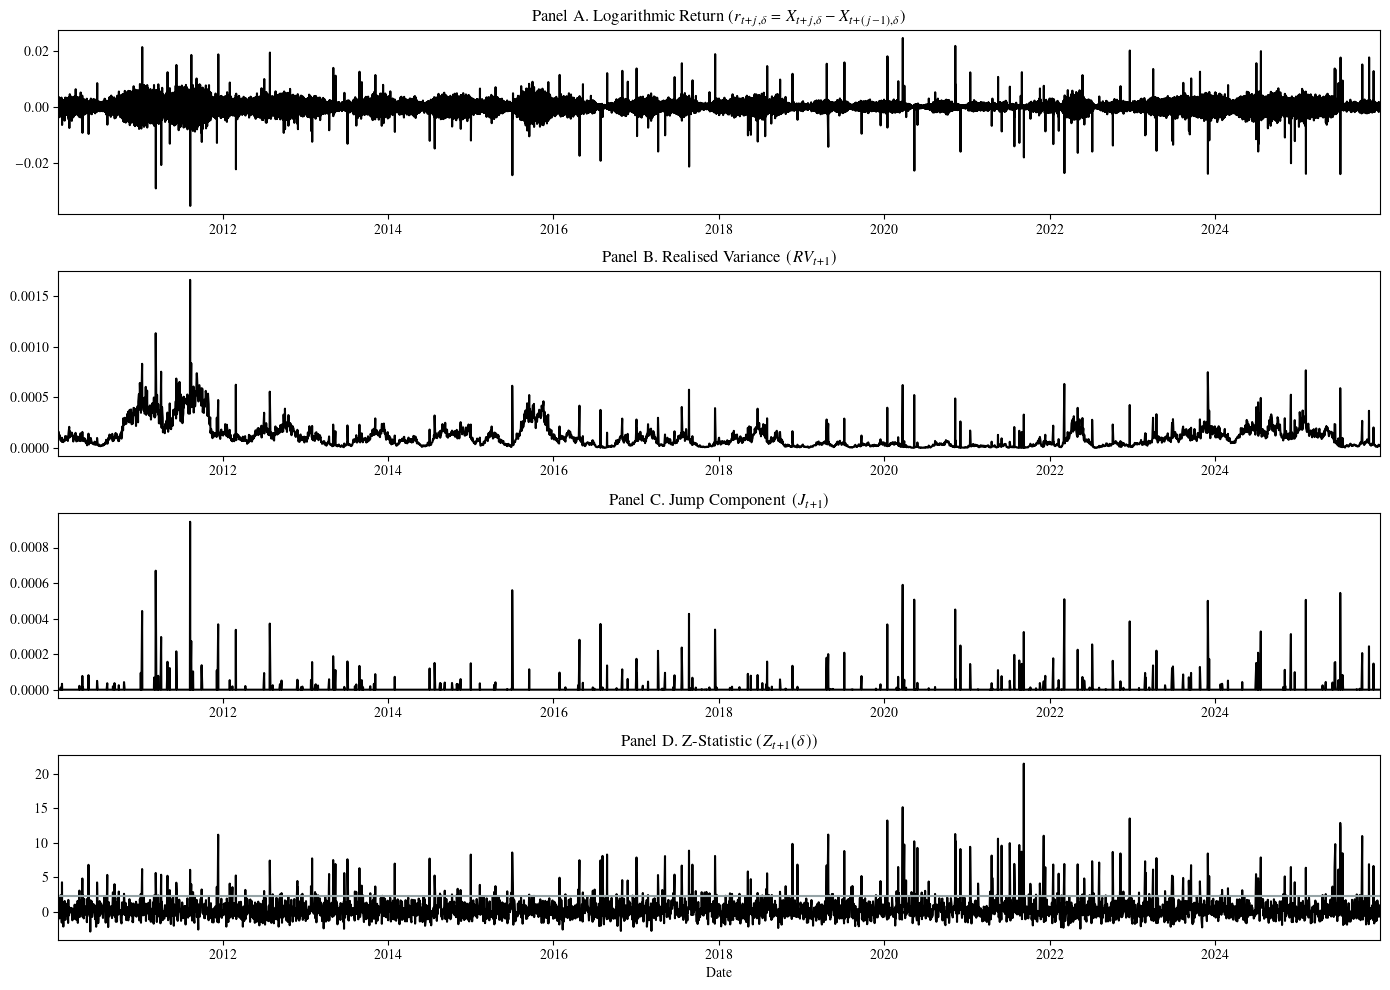

In [3]:
# The plot function expects that the input dataframes have a pandas datetime
# object as index
return_df.index = return_df["timestamp"]
return_df = return_df["log_return"]

fig = plot_overview(
    return_df=return_df,
    variance_df=variance_df,
    figsize=(14, 10),
    alpha=alpha
)